In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('digital_wallet_transactions.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 5000 non-null   int64  
 1   transaction_id      5000 non-null   object 
 2   user_id             5000 non-null   object 
 3   transaction_date    5000 non-null   object 
 4   product_category    5000 non-null   object 
 5   product_name        5000 non-null   object 
 6   merchant_name       5000 non-null   object 
 7   product_amount      5000 non-null   float64
 8   transaction_fee     5000 non-null   float64
 9   cashback            5000 non-null   float64
 10  loyalty_points      5000 non-null   int64  
 11  payment_method      5000 non-null   object 
 12  transaction_status  5000 non-null   object 
 13  merchant_id         5000 non-null   object 
 14  device_type         5000 non-null   object 
 15  location            5000 non-null   object 
dtypes: flo

Filtered dataset to include only successful transactions to ensure analysis reflects realized user spending and cashback activity.

Removed non-informative identifiers (idx, transaction_id) and overly granular fields (product_name, merchant_id) that do not contribute to behavioral insights.

Converted transaction_date to a proper datetime format to enable temporal analysis.

Added key features:

net_spend = product amount + transaction fee

cashback_rate = cashback ÷ product amount

In [2]:
df = df[df["transaction_status"] == "Successful"]
df.drop(columns=["idx"], inplace=True)
df.drop(columns=["transaction_id"], inplace=True)
df.drop(columns=["merchant_id"], inplace=True)
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["net_spend"] = df["product_amount"] + df["transaction_fee"]
df["cashback_rate"] = df["cashback"] / df["product_amount"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4755 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             4755 non-null   object        
 1   transaction_date    4755 non-null   datetime64[ns]
 2   product_category    4755 non-null   object        
 3   product_name        4755 non-null   object        
 4   merchant_name       4755 non-null   object        
 5   product_amount      4755 non-null   float64       
 6   transaction_fee     4755 non-null   float64       
 7   cashback            4755 non-null   float64       
 8   loyalty_points      4755 non-null   int64         
 9   payment_method      4755 non-null   object        
 10  transaction_status  4755 non-null   object        
 11  device_type         4755 non-null   object        
 12  location            4755 non-null   object        
 13  net_spend           4755 non-null   float64       
 1

Removed transaction_status after filtering to successful transactions, as it no longer provided additional analytical value.

Created time-based features from transaction_date to support trend, behavioral, and cohort analyses.

In [3]:
df.drop(columns=["transaction_status"], inplace=True)
df["month"] = df["transaction_date"].dt.to_period("M")
df["day_of_week"] = df["transaction_date"].dt.day_name()
df["hour"] = df["transaction_date"].dt.hour


In [4]:
df[["product_amount", "net_spend", "cashback"]].sum()


product_amount    23559018.92
net_spend         23678939.61
cashback            241451.82
dtype: float64

Total product amount (GMV):
  $23,559,018.92

Total net spend (incl. fees):
  $23,678,939.61
  
Total cashback paid:
  $241,451.82

In [5]:
cashback_rate_weighted = df["cashback"].sum() / df["product_amount"].sum()
cashback_rate_weighted * 100


np.float64(1.0248806235094274)

The platform processed approximately $23.56M in gross transaction volume across successful transactions.
After accounting for transaction fees, total user spend reached $23.68M.
Cashback incentives totaled $241K, representing approximately 1.02% of gross transaction value.
This indicates that cashback incentives are being deployed efficiently relative to overall platform spending.

In [7]:
df.groupby("product_category")[["net_spend", "cashback"]].sum().sort_values("net_spend", ascending=False)

,net_spend,cashback
product_category,,
Streaming Service,1394383.33,14800.13
Water Bill,1355885.48,13355.52
Gas Bill,1304272.65,11651.42
Education Fee,1297879.27,13870.11
Movie Ticket,1285635.78,13256.15
Food Delivery,1268364.97,13064.75
Hotel Booking,1257837.15,12928.58
Taxi Fare,1247193.43,12802.32
Rent Payment,1210760.47,12372.34


The platform benefits from a balanced mix of essential and discretionary spending categories.
This diversification reduces dependency on any single category while providing multiple touch points for user engagement.
Optimizing cashback incentives in high-frequency categories (e.g., utilities, subscriptions) may improve retention, while targeted boosts in discretionary categories (e.g., travel, entertainment) could drive incremental spend.

C:\Windows\Temp\ipykernel_13652\2490501828.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["cashback"].sum() / x["net_spend"].sum())


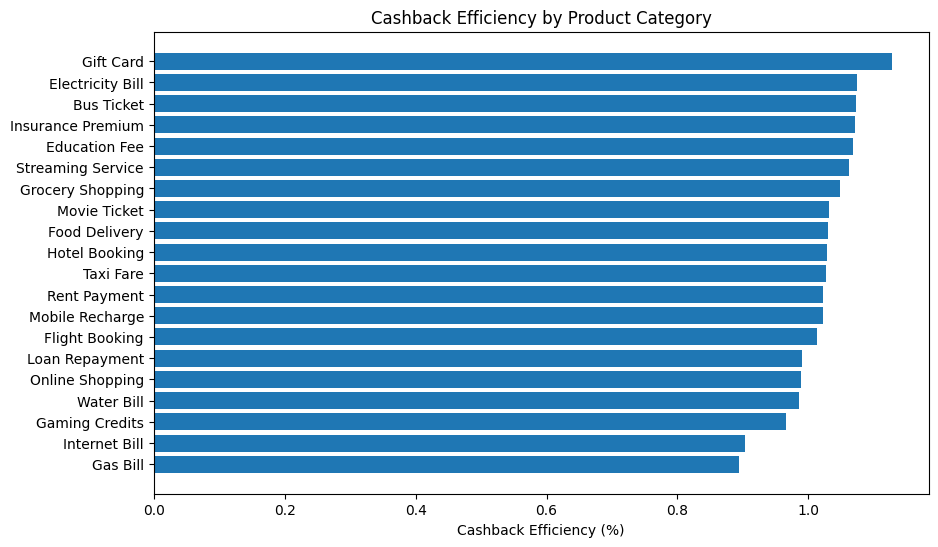

In [10]:
category_efficiency = (
    df.groupby("product_category")
      .apply(lambda x: x["cashback"].sum() / x["net_spend"].sum())
      .sort_values(ascending=False)
      .reset_index(name="cashback_efficiency")
)
category_efficiency

category_efficiency['cashback_efficiency'] *= 100

plt.figure(figsize=(10, 6))
plt.barh(
    category_efficiency["product_category"],
    category_efficiency["cashback_efficiency"]
)
plt.xlabel("Cashback Efficiency (%)")
plt.title("Cashback Efficiency by Product Category")
plt.gca().invert_yaxis()
plt.show()


The relatively narrow spread in cashback efficiency suggests a standardized incentive framework across categories. However, small efficiency differences become meaningful at scale, particularly in high-frequency or high-volume categories. Optimizing incentive allocation in these segments could materially reduce costs without negatively impacting user engagement.

Next goal is to understand how user spending, cashback exposure, and engagement differ across the user base to identify high-value and incentive-sensitive users.

In [12]:
user_metrics = (
    df.groupby("user_id")
      .agg(
          transactions=("product_amount", "count"),
          total_spend=("net_spend", "sum"),
          avg_cashback_rate=("cashback_rate", "mean"),
          total_cashback=("cashback", "sum"),
          loyalty_points=("loyalty_points", "sum")
      )
      .reset_index()
)


In [13]:
user_metrics["total_spend"].describe()


count     3783.000000
mean      6259.302038
std       4112.009405
min         18.800000
25%       3078.125000
50%       5974.040000
75%       8592.635000
max      28918.110000
Name: total_spend, dtype: float64

What the numbers show:

    3,783 active users generated successful transactions during the analysis period.

    Average total spend per user: ~$6,259

    Median total spend: ~$5,974

    Maximum user spend: ~$28,918

The mean being slightly higher than the median indicates a right-skewed distribution, where a subset of high-spending users pulls the average upward.

In [14]:
user_metrics["transactions"].describe()


count    3783.000000
mean        1.256939
std         0.520407
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: transactions, dtype: float64

What the numbers show:

    3,783 users completed at least one successful transaction.

    Median transactions per user: 1

    75% of users made only 1 transaction

    Maximum transactions per user: 4

    Average transactions per user: ~1.26

This indicates a low transaction frequency distribution, with most users engaging in one-off or infrequent transactions.

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(
    user_metrics["avg_cashback_rate"] * 100,
    user_metrics["total_spend"],
    alpha=0.5
)
plt.xlabel("Average Cashback Rate (%)")
plt.ylabel("Total User Spend")
plt.title("User Spend vs Average Cashback Rate")
plt.show()
